In [179]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [180]:
from sklearn.model_selection import train_test_split, GroupKFold, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.inspection import permutation_importance
from sklearn.linear_model import Lasso
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectFromModel

import category_encoders as ce

# Where to put a store?

## $\S$1. EDA

### $\S$1.1 EDA : Exploratory data analysis split

Let's load up the training data, and do some sanity checks. The big things that I am looking for are
* data quality issues (is there missing data, and if so, how much)?
* how much data is there?

If we have very little data, we need to ensure that our EDA doesn't contribute to overfitting by us making decisions on data that survives through each cross-fold of validation. If we have a lot of training data, or we expect to add data at a significant rate, we can worry less about this.

In [181]:
train = pd.read_csv('data/train.csv')

In [182]:
#number of nulls?
nulls = train.isna().sum()
nulls[nulls > 0]

directionCode    58
dtype: int64

In [183]:
# Make the training data actually a date
train['date'] = pd.to_datetime(train['date'])

Okay, so 58 missing values in the direction code. We also want a notion of how many rows of data we have:

In [184]:
len(train)

5059

### $\S$1.2 EDA: Independent units of data

We have 5059 rows of data, but the data may not be independent. For example, we have date information -- but if the data was collected from the same store on multiple days, those rows are not independent. In an extreme case, we might have only one store being measured over and over again, which wouldn't help us generalize to new stores! If there was only one store in the data set:

* We **could** use the data set to make predictions on new dates in the data set
* We should **not** try to use the data set to make predictions about new stores

We can tell from the multiple regions that the number of stores is bigger than one (a store is assumed to be in only one "region"). 


This is important because it influences our cross-validation design. The goal is to make predictions about opening a **new store**, where we have no previous information. If we train on data that has a store in the training _and_ cross-validation folds, then data can leak -- we will know information about an existing store in the training set when looking at our cross-validation fold, and information about the store might get encoded in otherwise marginal features. This will lead to us being overly confident when generalizing to new stores.

_If_ we have the same store repeated multiple times, the correct thing to do is to use grouped cross validation, where each store belongs to a single fold. 

If there was a `store_id` this would be easy to determine. Unfortunately we don't have that. Our goal instead will be to look at the number of rows of data in a given region on a given day. If this is constant, _and_ we see features that would not change day-to-day (e.g. number of parking spots, number of seats), we have confidence that we are looking the same store.

In [185]:
stores_by_date_and_region = train.groupby(['date', 'region']).deltaRevenue.count().reset_index().rename(columns={'deltaRevenue': 'count'})
stores_by_date_and_region

,date,region,count
0,2018-01-10,8,3
1,2018-01-11,8,3
2,2018-01-12,8,3
3,2018-02-10,8,3
4,2018-02-11,8,3
...,...,...,...
2370,2020-12-02,5,3
2371,2020-12-02,6,1
2372,2020-12-02,7,2
2373,2020-12-02,9,3


In [186]:
stores_by_date_and_region.groupby('region')['count'].describe()

,count,mean,std,min,25%,50%,75%,max
region,,,,,,,,
1,354.0,4.115819,2.556030,1.0,2.0,2.0,7.0,7.0
2,293.0,1.815700,0.388392,1.0,2.0,2.0,2.0,2.0
3,284.0,1.869718,0.337207,1.0,2.0,2.0,2.0,2.0
4,261.0,1.000000,0.000000,1.0,1.0,1.0,1.0,1.0
5,227.0,1.621145,0.925113,1.0,1.0,1.0,3.0,3.0
6,213.0,1.000000,0.000000,1.0,1.0,1.0,1.0,1.0
7,136.0,1.426471,0.496392,1.0,1.0,1.0,2.0,2.0
8,365.0,2.953425,0.247005,1.0,3.0,3.0,3.0,3.0
9,150.0,2.220000,0.975333,1.0,1.0,3.0,3.0,3.0


So regions 4, 6, and 10 only show one store consistently. Let's see if we can plausibly say it is the _same_ store by looking at some features that should not change day to day. The easiest of these are "seats" and "parking spots"

In [187]:
train[train.region.isin([4, 6, 10])].groupby(['region', 'Seats', 'Parking_slots']).deltaRevenue.count()

region  Seats  Parking_slots
4       86     0                261
6       100    37               213
10      131    31                92
Name: deltaRevenue, dtype: int64

Okay, it is plausable that these really are the same store (it isn't proof, but is highly indicative) -- otherwise we have a lot of different stores that just happen to have the same number of seats and parking_slots in a region!

Let's investigate deeper. Let's ask 

> "what are the range of values for `(region, parking slots, seats)` when we scan over the dates?"



In [188]:
stores_in_training = train.groupby(['region', 'Seats', 'Parking_slots']).date.nunique()
stores_in_training

region  Seats  Parking_slots
1       53     15               329
        94     17               155
        100    13               155
        106    15               353
        120    31               155
        162    0                155
        188    217              155
2       64     80               293
        92     30               239
3       158    0                284
        210    0                247
4       86     0                261
5       57     21               227
        119    2500              70
        126    1000              71
6       100    37               213
7       60     61               136
        80     600               58
8       73     0                360
        105    0                359
        151    0                359
9       52     36                92
        110    1500             150
        548    1900              91
10      131    31                92
Name: date, dtype: int64

This suggests that what we actually have is 
* 7 stores in region 1,
* 2 stores in region 2,
* 2 stores in region 3,
* 1 store in region 4
* 3 stores in region 5
* 1 store in region 6
* 2 stores in region 7
* 3 stores in region 8
* 3 stores in region 9
* 1 store in region 10

The different stores have different amounts of data (e.g. the stores in region 1 have data for 155 days, 329 days, or 353 days).

### Bottom line

**We cannot treat the rows of data as independent**. When doing cross-validation, we must ensure that each store is either in the fold, or out -- no having some rows of a store being in the training fold, and some being in the validation set.


I also need to check that the validation set does not contain data leakage. Usually I would not load validation data until the process was complete. Here I am looking to see if the "other days" from the existing stores are in the validation set ... if so, this would not be a design that would generalize to new stores.

In [189]:
validation = pd.read_csv('data/validation.csv')

In [190]:
stores_in_validation = validation.groupby(['region', 'Seats', 'Parking_slots']).date.nunique()
stores_in_validation

region  Seats  Parking_slots
4       97     0                258
5       92     0                 71
7       78     30               136
9       130    38                92
Name: date, dtype: int64

Okay, none of these stores overlap (😌). I don't have to worry that my data is going to leak! Let's just explicitly verify that there are no stores "in common", assuming that `(region, Seats, Parking_slots`) uniquely identifies a stores:

In [191]:
stores_in_validation.reset_index().merge(stores_in_training.reset_index())

,region,Seats,Parking_slots,date


No overlap!!

### Conclusion of independent data sets

- we have many data points _per store_; we should not treat the rows as independent
  - in particular, we have 5059 rows, but only **25** stores in our data set
- the validation set is correctly designed (contains no stores from the training set)
- in lieu of a store_id, we will assume that `(region, parking, seats)` uniquely identify a store, and generate a store id from it
- we will use grouped cross-validation to help us generalize our results better
- the validation dataframe will be deleted to ensure we don't accidentally peek at the results (verifying design seems like a legitimate case for peaking)

In [192]:
del validation

In [193]:
train['store_id'] = train.apply(lambda row: (row.region, row.Parking_slots, row.Seats), axis=1)

### $\S$1.3 EDA: missing data

We saw about that there was some missing data in only one column, the `directionCode`. Presumably these are encodings of the four cardinal directions, but let's check:

In [194]:
train.directionCode.value_counts(dropna=False, normalize=True)

1.0    0.301641
3.0    0.278711
4.0    0.218620
2.0    0.189563
NaN    0.011465
Name: directionCode, dtype: float64

Looks like the four cardinal points, with slight overweighting on directions 1 and 3. If this turns out to be an important feature, we can impute the values with 1.0 (the most common value) or randomly impute and do many times ("bootstrapping" to measure the uncertainty). 


Let's check the "store_id" argument, and ask if rows of the same store has a directionCode

In [195]:
train.groupby('store_id').directionCode.value_counts(dropna=False)

store_id        directionCode
(1, 0, 162)     3.0              155
(1, 13, 100)    1.0              155
(1, 15, 53)     4.0              329
(1, 15, 106)    2.0              353
(1, 17, 94)     4.0              155
(1, 31, 120)    3.0              155
(1, 217, 188)   4.0              155
(2, 30, 92)     1.0              239
(2, 80, 64)     3.0              293
(3, 0, 158)     4.0              284
(3, 0, 210)     2.0              247
(4, 0, 86)      1.0              261
(5, 21, 57)     3.0              227
(5, 1000, 126)  3.0               71
(5, 2500, 119)  1.0               70
(6, 37, 100)    1.0              213
(7, 61, 60)     1.0              136
(7, 600, 80)    NaN               58
(8, 0, 73)      1.0              360
(8, 0, 105)     2.0              359
(8, 0, 151)     3.0              359
(9, 36, 52)     4.0               92
(9, 1500, 110)  3.0              150
(9, 1900, 548)  4.0               91
(10, 31, 131)   1.0               92
Name: directionCode, dtype: int64

Interesting, all 58 missing values are associated with a single store. It might be legitimately missing, or this store may not face one of the cardinal directions. We don't want to weigh a direction more simply because a store has more measurements, so if we do need to impute, we should base it off the distribution of directions that *stores* face, not the distribution of directions that *measurements* take. 

That is, what I really want is the frequency of directionCodes from _this_ table.

In [196]:
train.groupby('directionCode', dropna=False).store_id.nunique()

directionCode
1.0    8
2.0    3
3.0    7
4.0    6
NaN    1
Name: store_id, dtype: int64

This would still suggest that if the `directionCode` was an important feature, we would impute it using direction 1.

### $\S$1.4 EDA: are categorical variables unique per "store_id"

We have some categorical variables which seem to be a description of the market or area (namely `mtype` and `type_dfsf`). We would hope these are constant for a particular store, but let's check!

In [197]:

train.groupby('store_id')[['mtype', 'type_dtsf']].nunique()

,mtype,type_dtsf
store_id,,
"(1, 0, 162)",1,1
"(1, 13, 100)",1,1
"(1, 15, 53)",1,1
"(1, 15, 106)",1,1
"(1, 17, 94)",1,1
"(1, 31, 120)",1,1
"(1, 217, 188)",1,1
"(2, 30, 92)",1,1
"(2, 80, 64)",1,1


Yes, these are unique variables for a store! We could concatanate them onto the store_id key, but there is no need at the moment. Let's also see what the distribution in values is:

In [198]:
train.groupby(['mtype']).store_id.nunique()

mtype
Hyper        5
Rural        3
Suburban     5
Urban       12
Name: store_id, dtype: int64

In [199]:
train.groupby(['type_dtsf']).store_id.nunique()

type_dtsf
DT       14
FoodC     1
Mall      2
SF        8
Name: store_id, dtype: int64

In [200]:
# And now the cross distribution
train.groupby(['mtype', 'type_dtsf']).store_id.nunique()

mtype     type_dtsf
Hyper     SF           5
Rural     DT           3
Suburban  DT           3
          FoodC        1
          Mall         1
Urban     DT           8
          Mall         1
          SF           3
Name: store_id, dtype: int64

i.e. we only have a small subset of the fully crossed types, so we would be unwise to include interaction effects.

We can also verify that the numerical features other than Seats, Parking_slots, and region vary across day (i.e. we don't have other "constants" that id the store). Looking at the non-proprietary features first:

In [201]:
features_to_map = [
    'directionCode',
    'totalActivitiesRefcircle',
    'totalCustomersRefcircle',
    'transactCount',
    'totalRevenue',
    'Seats',
    'Parking_slots',
    'region',
    'deltaRevenue'
]

train.groupby('store_id')[features_to_map].var()

,directionCode,totalActivitiesRefcircle,totalCustomersRefcircle,transactCount,totalRevenue,Seats,Parking_slots,region,deltaRevenue
store_id,,,,,,,,,
"(1, 0, 162)",0.0,5.634927e+05,108592.250775,404.471973,3.685018e+08,0.0,0.0,0.0,361.034792
"(1, 13, 100)",0.0,2.305412e+06,372670.836028,382.307750,6.241073e+08,0.0,0.0,0.0,968.873756
"(1, 15, 53)",0.0,1.380189e+05,21426.396304,561.939395,7.569915e+08,0.0,0.0,0.0,700.144777
"(1, 15, 106)",0.0,1.612085e+06,245438.890549,467.633724,6.965732e+08,0.0,0.0,0.0,739.081524
"(1, 17, 94)",0.0,2.715052e+06,342394.173691,298.786929,5.935888e+08,0.0,0.0,0.0,980.683542
"(1, 31, 120)",0.0,4.531734e+06,593939.605111,523.933389,1.110002e+09,0.0,0.0,0.0,903.367654
"(1, 217, 188)",0.0,1.103942e+06,155178.546879,503.422539,8.521950e+08,0.0,0.0,0.0,902.187753
"(2, 30, 92)",0.0,8.974360e+05,84107.484336,229.192855,4.413351e+08,0.0,0.0,0.0,704.261406
"(2, 80, 64)",0.0,9.312435e+05,101112.191477,158.405068,2.766345e+08,0.0,0.0,0.0,746.661091


Now looking at the proprietary (i.e. `r_*`) features:

In [202]:
train.groupby('store_id')[[c for c in train.columns if 'r_' in c]].var()

,r_11,r_12,r_13,r_14,r_1e,r_21,r_22,r_23,r_24,r_2e,r_31,r_32,r_33,r_34,r_3e,r_41,r_42,r_43,r_44,r_4e
store_id,,,,,,,,,,,,,,,,,,,,
"(1, 0, 162)",0.001001,0.001155,0.005395,0.006296,0.000040,0.001275,0.000335,0.002896,0.006575,0.000213,0.008937,0.003209,0.001177,0.002545,0.000011,0.005419,0.006996,0.001649,0.000721,0.000007
"(1, 13, 100)",0.000326,0.001198,0.003424,0.001476,0.000124,0.000989,0.000213,0.001166,0.006245,0.000003,0.003961,0.000981,0.000428,0.001148,0.000002,0.001328,0.004548,0.001545,0.001195,0.000013
"(1, 15, 53)",0.018857,0.036865,0.054026,0.033617,0.001750,0.058517,0.016003,0.004598,0.009365,0.000017,0.077743,0.004018,0.014562,0.036114,0.000145,0.013988,0.005709,0.040146,0.014747,0.002168
"(1, 15, 106)",0.014679,0.003509,0.001902,0.007179,0.000003,0.004042,0.012226,0.002645,0.049495,0.000076,0.002488,0.001836,0.016048,0.003768,0.000796,0.008611,0.051729,0.004822,0.011941,0.000052
"(1, 17, 94)",0.001104,0.001658,0.005145,0.000689,0.000002,0.001168,0.000337,0.001899,0.002953,0.000001,0.004227,0.002507,0.001110,0.000548,0.000025,0.000855,0.002835,0.001039,0.000358,0.000040
"(1, 31, 120)",0.000303,0.000599,0.001267,0.000896,0.000005,0.000476,0.000566,0.000584,0.000846,0.000058,0.001980,0.000759,0.001248,0.000808,0.000003,0.000972,0.001289,0.000913,0.000437,0.000001
"(1, 217, 188)",0.000855,0.001983,0.008055,0.002691,0.000011,0.001616,0.000286,0.003902,0.005852,0.000002,0.006768,0.003560,0.000740,0.002100,0.000038,0.002889,0.010076,0.002375,0.000305,0.000235
"(2, 30, 92)",0.005116,0.001412,0.002080,0.027771,0.001104,0.002421,0.002304,0.002020,0.049324,0.000134,0.002780,0.001863,0.003692,0.025915,0.000051,0.031344,0.032874,0.023101,0.026566,0.001406
"(2, 80, 64)",0.008184,0.047202,0.049349,0.004986,0.000074,0.050552,0.001985,0.001804,0.009868,0.000979,0.054484,0.002554,0.001345,0.001578,0.000136,0.004089,0.004852,0.001259,0.002358,0.000006


**Bottom line:**

Market type and store type are constant across `store_id`, but the other features vary from day-to-day within a particular store.

We will need to model variables that ID a store `(region, parking, seats, market type, store type)` to get information relevant about the store, and the other information will be time varying. We only have 25 independent points for modeling these 5 variables, so we will need a pretty simple model!

### $\S$1.5 EDA: Looking at variables and their relationship to the output

Let's steer clear of the novel features for the moment. We will test them for predictive power separately, but let's start with the interpretable features and their correlation with the desired output.

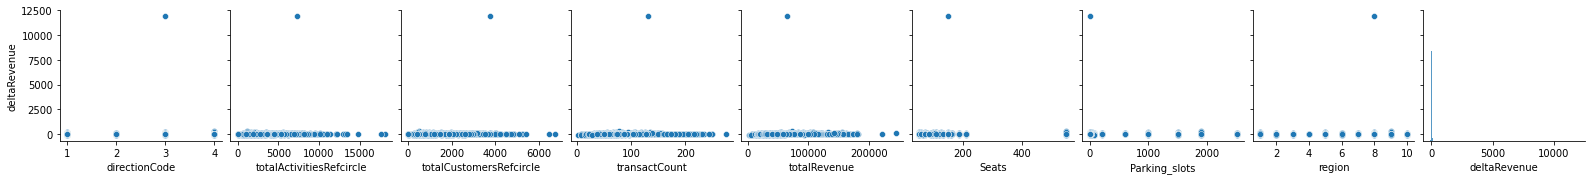

In [203]:
sns.pairplot(data=train, 
             x_vars=features_to_map,
             y_vars='deltaRevenue')

Okay, we have a clear outlier in our dataset! We should see how big a problem this is (it is likely a data error or a extreme event that caused revenue to go up for unexpected reasons).

In [204]:
train.sort_values('deltaRevenue', ascending=False).head()

,date,directionCode,r_11,r_12,r_13,r_14,r_1e,r_21,r_22,r_23,...,transactCount,totalRevenue,Seats,Parking_slots,type_dtsf,mtype,isholiday,region,deltaRevenue,store_id
2569,2019-09-08,3.0,0.858212,0.197115,0.156658,0.223558,0.005147,0.127404,0.739927,0.153846,...,131,64520,151,0,SF,Hyper,no,8,11912.987300,"(8, 0, 151)"
3862,2020-11-02,4.0,0.577320,0.170213,0.500000,0.375000,0.000000,0.127660,0.805195,0.051948,...,77,72990,548,1900,FoodC,Suburban,yes,9,267.984064,"(9, 1900, 548)"
3273,2020-11-02,3.0,0.708333,0.098446,0.071429,0.142857,0.058333,0.103627,0.786070,0.071429,...,75,90430,57,21,DT,Rural,yes,5,248.054389,"(5, 21, 57)"
3468,2019-01-27,3.0,0.862524,0.131387,0.125000,0.166667,0.009416,0.094891,0.874539,0.052632,...,84,54800,151,0,SF,Hyper,no,8,243.668116,"(8, 0, 151)"
19,2020-02-24,1.0,0.819168,0.079872,0.158730,0.080321,0.054250,0.092652,0.870702,0.076613,...,106,106800,100,13,DT,Urban,yes,1,231.590213,"(1, 13, 100)"


Okay, let's drop the one obvious outlier (that is almost certainly a data error)

In [205]:
train = train[train.deltaRevenue < 300]

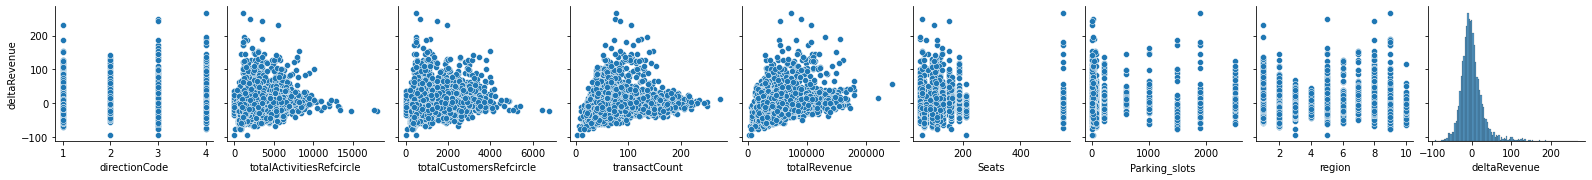

In [206]:
sns.pairplot(data=train, 
             x_vars=features_to_map,
             y_vars='deltaRevenue')

A few callouts here:

1. Both `transactCount` and `totalRevenue` are positively correlated with `deltaRevenue`. Basically the more your store does in revenue, the more we expect the `deltaRevenue` to be
2. Depending on whether `transactCount` and `totalRevenue` are of the _existing_ store or the _new_ store, it may or may not be fair to include it. In both cases, we don't actually have the measurement of transations of revenue until the day in question, so we wouldn't be able to put measured values into our model!
  - If it is for the transactions of the _existing store_, we probably should not include it. We have measurements of the typical revenue of the store _after_ the new store was put in, but we don't know what it was before. The thing that we are trying to measure is the effect of putting the store in!
    - We could do something a more complicated: use `deltaRevenue` to reconstruct the revenue _before_ the new store moved in, determine the previous revenue `train['counterFactualRevenue'] = train['totalRevenue']/(1 + train['deltaRevenue']/100)`. Then we could use estimates of the existing store performance for the feature `counterFactualRevenue`, and we don't have `totalRevenue` as a feature at all. We would also do this transformation on the validation set (it looks circular but isn't as long as we don't use `totalRevenue` -- it is assuming the way we would use this is projecting the current revenue of the store in the absence of the change).
  - If it for the transactions of the _new store_, we still don't have the data, but we could use the information strategically. For example, if we know that we need to do at least 100 transactions for the new store to be viable, it makes sense to ask "we are going to put a store here, and have at least 100 transactions in it" to assess the impact and check we do not cannibalise the existing store too much.
  - At the moment, I will include these features, as it isn't clear what the meaning of them are, so I will allow myself to include them. I am just including notes of how we would modify these fields
3. We should check for colinearity in general, but in particular between `transactCount` and `totalRevenue` (we would expect Revenue and Transactions to be strongly correclated!)
4. We have masked the effect of time -- a lot of the scatter can come about by looking at the same store on different days (especially for `region`, `Parking_slots` , and `Seats`)
5. `totalActivitiesRefcircle` and `totalCustomerRefcircle` also have roughly the same shape as `transactCount` and `totalRevenue` (at least just looking at it on this scale).

Let's look at possible correlations between `totalActivitiesRefcircle`, `totalCustomerRefcircle`, `transactCount`, and `totalRevenue`:

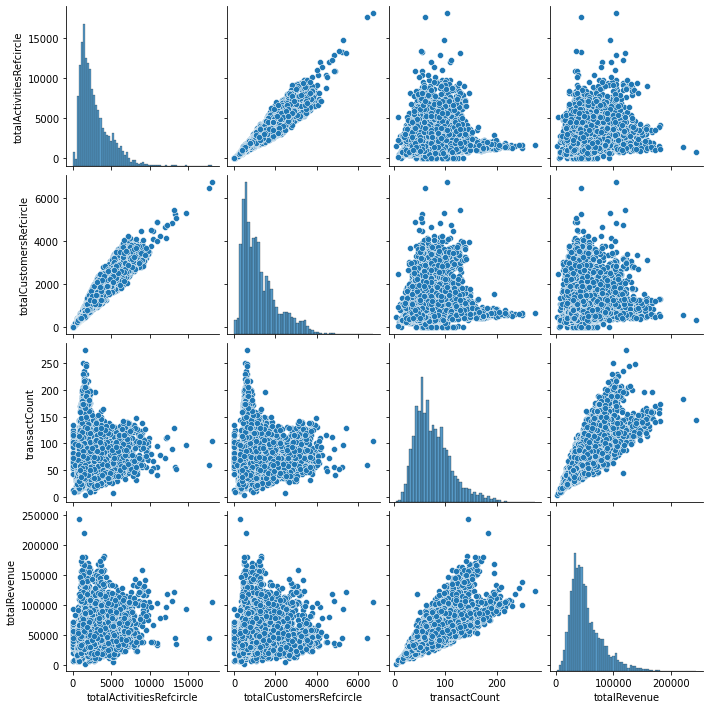

In [207]:
sns.pairplot(data=train[['totalActivitiesRefcircle', 'totalCustomersRefcircle', 
                         'transactCount', 'totalRevenue']])

We see activities and customers are both strongly correlated, so we should not include both of these features. We also see a moderate correlation between `transactCount` and `totalRevenue`. Finally, we also see that each of these distribution is right-skewed (i.e. the right tail is longer), making them good candidates for logging.

This also makes sense, as we are interested in percentage variation in revenue (relative changes are multiplicative in `totalRevenue`, but _additive_ on `log(revenue)`). 

We would also expect things like
- day of week
- holiday events
to affect the revenue by a mulplicative factor rather than an additive one (e.g. it seems reasonable that Monday's sales would be 20% higher than Wednesday's same-store sales, rather than $10k better regardless of the size of the store).

Let's check that now by looking at time-series for a couple of the stores:

<AxesSubplot:xlabel='date'>

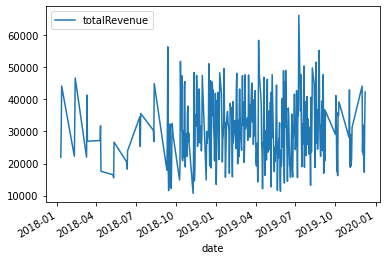

In [208]:
train[train.store_id==(8,0,105)].plot('date', 'totalRevenue')

<AxesSubplot:xlabel='date'>

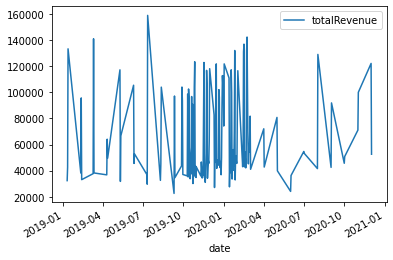

In [209]:
train[train.store_id==(1, 31, 120)].plot('date', 'totalRevenue')

Both of these randomly chosen stores look reasonably stationary (no long term trend). The revenue scales are very very different, but it is reasonable to think that we have a certain fraction of sales on different ways of the week (e.g. Monday's are 20% higher than Wednesdays, but Tuesdays are 10% lower). It doesn't look reasonable from the graph to assume this happens in absolute values.

The no long term trend certainly makes modeling easier. Let's try logging the variables:

In [210]:
train['log_revenue'] = np.log1p(train['totalRevenue'])
train['log_activity'] = np.log1p(train['totalActivitiesRefcircle'])
train['log_transaction'] = np.log1p(train['transactCount'])

/Users/damienmartin/anaconda3/envs/hela/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/Users/damienmartin/anaconda3/envs/hela/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/damienmartin/anaconda3/envs/hela/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.


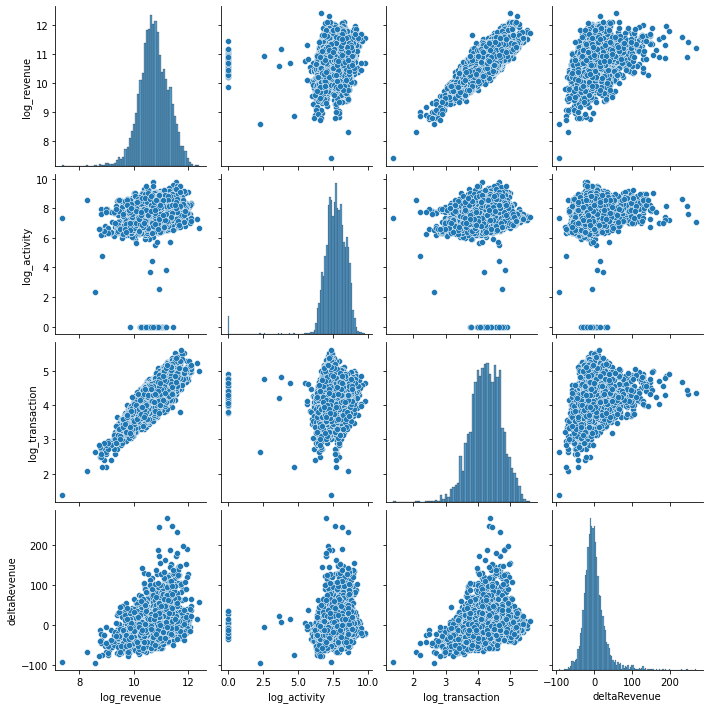

In [211]:
sns.pairplot(data=train[['log_revenue', 'log_activity', 'log_transaction', 'deltaRevenue']])

We also see post-transformation that a lot of the same information is contained in the transaction and revenue data, so we should only keep one (and -- as argued above -- possibly neither if we are concerned about leakage).

Let's see how this varies by store:

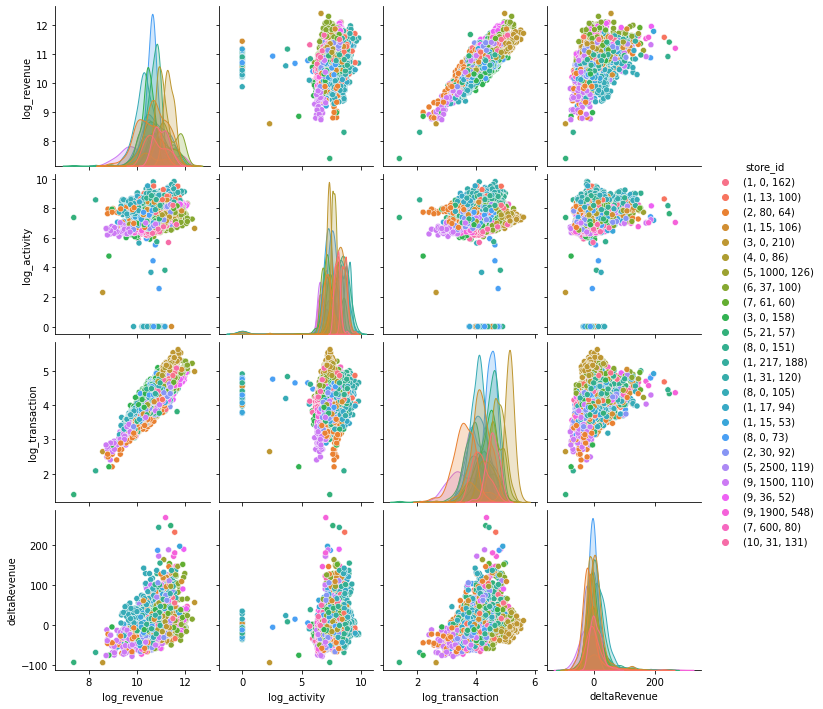

In [212]:
sns.pairplot(data=train[['store_id', 'log_revenue', 'log_activity', 'log_transaction', 'deltaRevenue']],
            hue='store_id')

There are a few stores here , but interestingly we can tell that each store has a distinct transaction and revenue amount, but the delta revenue has a similar shape for all the different stores. This suggests we would not lose a lot by standard scaling the different transaction data (where we do the standard scaling store-by-store).

#### How does store type matter

We will have new stores in the validation set, but we know things about the stores (e.g. number of parking slots, number of seats, market type, etc). How does the distribution change for different attributes? e.g. can we predict revenue based on the parking slots? The seats? The region?

Let's start with market type:

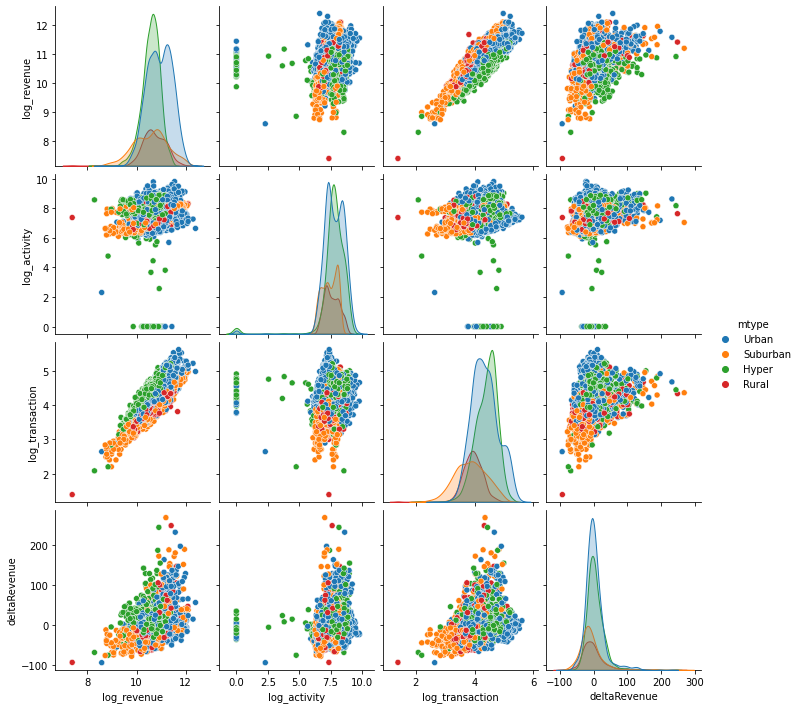

In [213]:
sns.pairplot(data=train[['mtype', 'log_revenue', 'log_activity', 'log_transaction', 'deltaRevenue']],
            hue='mtype')

Okay, that's interesting -- we see a difference in the distribution of `deltaRevenue` based on market type **and** we see different distributions of transaction and revenue data, suggesting we keep both. The activity is more or less unaffected by market type. 

The observation of the different revenue and transaction data is particularly useful **if** we decide that we cannot use

Let's do the same for `type_dtsf`

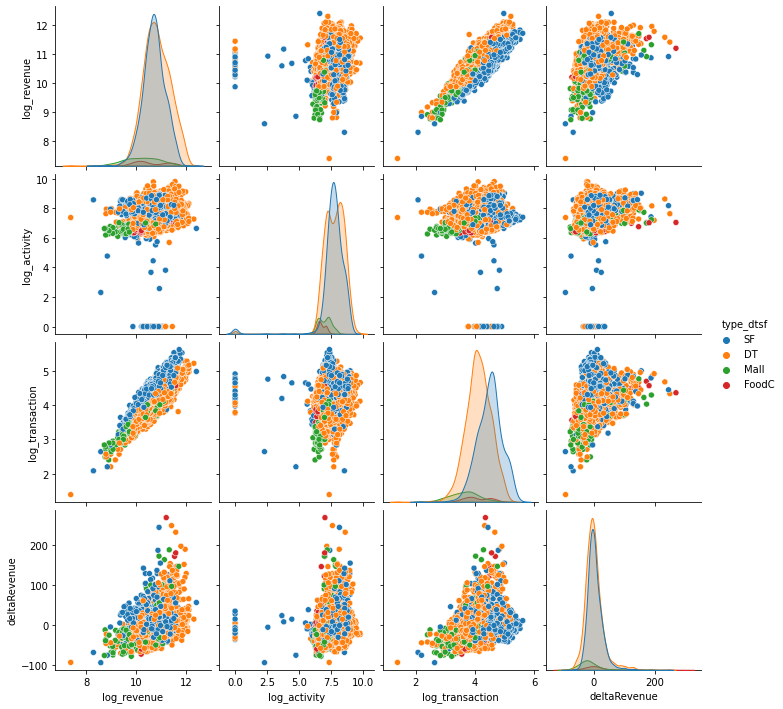

In [214]:
sns.pairplot(data=train[['type_dtsf', 'log_revenue', 'log_activity', 'log_transaction', 'deltaRevenue']],
            hue='type_dtsf')

Except in transaction data, we don't see much difference. We also know `Mall` and `FoodC` are pretty small categories, so we should be suspicious of inference we draw. In a more involved project, we could use a [James-Stein encoder](https://kiwidamien.github.io/james-stein-encoder.html) (personal blog post). In this case, we will drop `type_dtsf` from the model.

**Note**

Because of lack of time, I have not verified that each market type and each `type_dtsf` has the same distribution of days of the week, and of holidays, which could potentially skew results. This would be something I would look at more closely in a real project.

Finally, let's look at the region:

In [216]:
train.head().T

,0,1,2,3,4
date,2019-03-10 00:00:00,2019-05-12 00:00:00,2020-02-21 00:00:00,2019-10-23 00:00:00,2019-08-09 00:00:00
directionCode,3,1,1,3,2
r_11,0.779487,0.830565,0.829023,0.923077,0.882172
r_12,0.152542,0.164751,0.132353,0,0.215517
r_13,0.25,0.181818,0.166667,0,0.104408
r_14,0.152542,0.166667,0.116883,0.25,0.159574
r_1e,0,0.038206,0.0373563,0,0.00204918
r_21,0.135593,0.1341,0.161765,0,0.181034
r_22,0.876056,0.871275,0.873127,0.80303,0.611285
r_23,0.204819,0.0786517,0.128631,0.118644,0.0940171


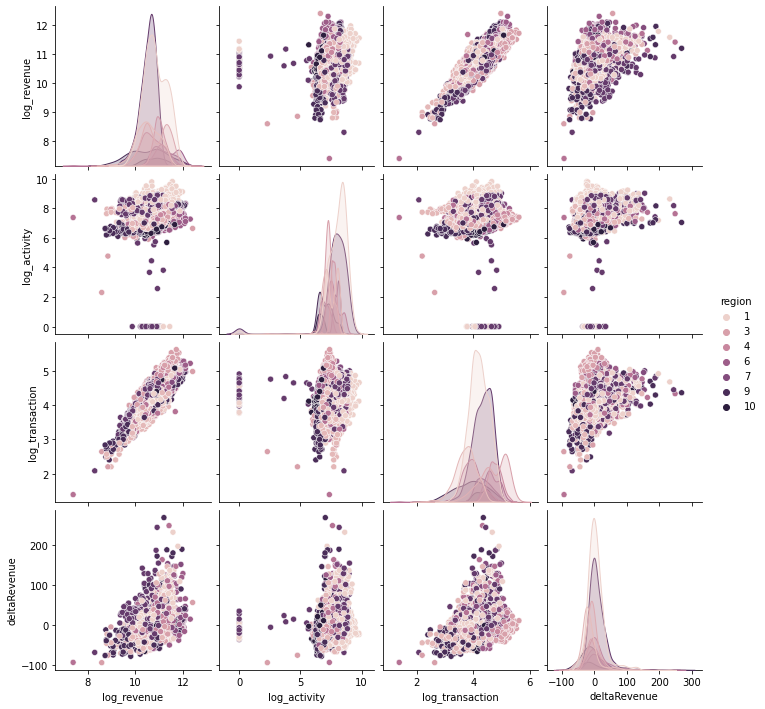

In [218]:
sns.pairplot(data=train[['type_dtsf', 'log_revenue', 'log_activity', 'log_transaction', 'deltaRevenue', 'region']],
            hue='region')

There is significant information contained in the region (the distributions look slightly different in terms of where the mode is). This is probably worth keeping _provided that we are making predictions within the same set of regions_. We want to be a little cautious, as we only have a few stores per region, so there is a lot of variability.

**bottom line:**

1. We have seen that logging the revenue, activity, and transactions leads to non-skewed distributions
2. Particularly for revenue and transactions, it would make sense for other features like days of the week to affect this multiplicatively (same % effect, different absolute effects). This becomes an additive effect on the log. 
3. We have seen that the activity and customers are strongly correlated, and kept only activity
4. We have a hierarichal model, where we first have the information about the store (sample of 25), and then once we have the store we use the 100-300 points in time to make a prediction about `deltaRevenue`. We see that `mtype` seems to be relatively informative, but `type_dtsf` less so.
5. Region carries data! We only have a few stores in any given region (and only 25 stores overall), so we want to encode this information in a way that "shrinks" the value back toward the average.

### $\S$ 1.6: Day of week effects

We can ask how the day of week affects the delta Revenue

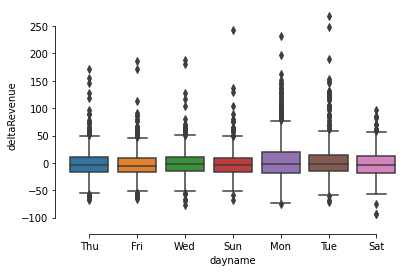

In [37]:
sns.boxplot(x="dayname", y="deltaRevenue",
            data=train)
sns.despine(offset=10, trim=True)

We see surprisingly little variatoin between days; Monday has slightly more variation and Saturday has less. What about holidays? How frequent are they?

In [38]:
train.isholiday.value_counts(normalize=True)

no     0.935745
yes    0.064255
Name: isholiday, dtype: float64

It is a relatively small fraction of data, so unlikely to have a huge effect. Let's see, anyway:

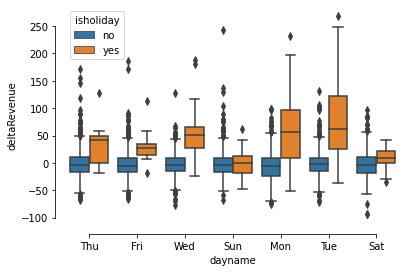

In [39]:
sns.boxplot(x="dayname", y="deltaRevenue",
            hue='isholiday',
            data=train)
sns.despine(offset=10, trim=True)

Holidays are actually pretty important, but easy to get washed out in regularization due to it applying to a relatively small set of the data.

## $\S$ 2: Preprocessing

### $\S$ 2.1: Making the features

In order to simplify things, let's assume the features are fixed (i.e. we know days of the week are Mon-Sun, and let's assume that we have agreed on a standard for what the `mtypes` should be).

If we **don't** assume this, we have to do our encoding as part of the cross fold validation (because we have to allow for unknown/new categories). This is slightly less robust to data changes, but louder about unexpected data (e.g. we will catch a day of the week being "sunday" instead of "Sun")

In [40]:
train.select_dtypes(include=[object,]).head()

,dayname,weekend,type_dtsf,mtype,isholiday,store_id
0,Thu,no,SF,Urban,no,"(1, 0, 162)"
1,Thu,no,DT,Urban,no,"(1, 13, 100)"
2,Fri,no,DT,Urban,no,"(1, 13, 100)"
3,Wed,no,DT,Suburban,no,"(2, 80, 64)"
4,Sun,yes,DT,Urban,no,"(1, 15, 106)"


* Drop weekend (redundent with dayname)
* Drop date
* Drop `type_dtsf` as per discussion above (a more complicated model would use it with a James-Stein encoder)
* One-hot encode `mtype`, `dayname`, `region`, and `directionCode` (the last two are numeric already, but they should not be ordered!)
* Turn `isholiday` into a integer

In [250]:
def load_data(path='data/train.csv', exclude_outputs_greater_than=300) -> pd.DataFrame:
    df = pd.read_csv(path)
    df = df[df.deltaRevenue < exclude_outputs_greater_than]
    df['log_revenue'] = np.log1p(df['totalRevenue'])
    df['log_transaction'] = np.log1p(df['transactCount'])
    df['log_activities'] = np.log1p(df['totalActivitiesRefcircle'])
    
    df['store_id'] = df.apply(lambda row: (row.region, row.Parking_slots, row.Seats), axis=1)
    
    df['isholiday'] = (train['isholiday']=='yes').astype(int)
    
    to_drop = [
        'totalRevenue', 'transactCount', 'totalActivitiesRefcircle', 'totalCustomersRefcircle',
        'weekend', 'type_dtsf', 'Parking_slots', 'Seats', 'date']
    return df.drop(to_drop, axis=1)

In [244]:
# Reload the training data and start from scratch

train = load_data(path='data/train.csv')


In [251]:
ohe_encoder = ce.OneHotEncoder(cols=['dayname', 'mtype', 'region', 'directionCode'],
                               use_cat_names=True,
                               return_df=True)
store_id_encoder = ce.OrdinalEncoder(cols=['store_id'], return_df=True)
train = store_id_encoder.fit_transform(train)
train = ohe_encoder.fit_transform(train)

/Users/damienmartin/anaconda3/envs/hela/lib/python3.7/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


In [44]:
train

,directionCode_3.0,directionCode_1.0,directionCode_2.0,directionCode_4.0,directionCode_nan,r_11,r_12,r_13,r_14,r_1e,...,region_6.0,region_7.0,region_8.0,region_9.0,region_10.0,deltaRevenue,log_revenue,log_transaction,log_activities,store_id
0,1,0,0,0,0,0.779487,0.152542,0.250000,0.152542,0.000000,...,0,0,0,0,0,-15.879277,10.659633,4.276666,8.168486,1
1,0,1,0,0,0,0.830565,0.164751,0.181818,0.166667,0.038206,...,0,0,0,0,0,25.210486,10.550355,4.110874,8.514189,2
2,0,1,0,0,0,0.829023,0.132353,0.166667,0.116883,0.037356,...,0,0,0,0,0,24.112387,11.138683,4.477337,8.694502,2
3,1,0,0,0,0,0.923077,0.000000,0.000000,0.250000,0.000000,...,0,0,0,0,0,-10.098617,9.936487,3.401197,7.189168,3
4,0,0,1,0,0,0.882172,0.215517,0.104408,0.159574,0.002049,...,0,0,0,0,0,7.282946,11.684279,4.584967,8.622994,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5054,1,0,0,0,0,0.651515,0.111111,0.222222,0.207317,0.000000,...,0,0,0,1,0,-42.156856,10.371019,3.637586,6.999422,21
5055,1,0,0,0,0,0.845571,0.192593,0.225941,0.216216,0.004263,...,0,0,1,0,0,-8.867721,10.611794,4.477337,8.842316,12
5056,1,0,0,0,0,0.830445,0.264840,0.223256,0.201474,0.003768,...,0,0,1,0,0,-21.495728,10.807118,4.304065,8.579792,12
5057,1,0,0,0,0,0.889328,0.189189,0.131148,0.101695,0.009223,...,0,0,1,0,0,-0.614073,10.968560,4.644391,8.184235,12


`store_id` is a number and isn't being used as a feature -- instead I am only using it to specify my groups for cross-fold validation

### $\S$ 2.2: preprocessing pipeline and KFold

In [45]:
scale_pipeline = Pipeline([
    ('scale', StandardScaler())
])

preprocess_pipeline = ColumnTransformer([
    ('scale', scale_pipeline, ['log_revenue', 'log_activities', 'log_transaction'])
], remainder='passthrough')


folds = GroupKFold(n_splits=5)
groups = train.store_id

X, y = train.drop(['deltaRevenue', 'store_id'], axis=1), train.deltaRevenue

In [46]:
train

,directionCode_3.0,directionCode_1.0,directionCode_2.0,directionCode_4.0,directionCode_nan,r_11,r_12,r_13,r_14,r_1e,...,region_6.0,region_7.0,region_8.0,region_9.0,region_10.0,deltaRevenue,log_revenue,log_transaction,log_activities,store_id
0,1,0,0,0,0,0.779487,0.152542,0.250000,0.152542,0.000000,...,0,0,0,0,0,-15.879277,10.659633,4.276666,8.168486,1
1,0,1,0,0,0,0.830565,0.164751,0.181818,0.166667,0.038206,...,0,0,0,0,0,25.210486,10.550355,4.110874,8.514189,2
2,0,1,0,0,0,0.829023,0.132353,0.166667,0.116883,0.037356,...,0,0,0,0,0,24.112387,11.138683,4.477337,8.694502,2
3,1,0,0,0,0,0.923077,0.000000,0.000000,0.250000,0.000000,...,0,0,0,0,0,-10.098617,9.936487,3.401197,7.189168,3
4,0,0,1,0,0,0.882172,0.215517,0.104408,0.159574,0.002049,...,0,0,0,0,0,7.282946,11.684279,4.584967,8.622994,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5054,1,0,0,0,0,0.651515,0.111111,0.222222,0.207317,0.000000,...,0,0,0,1,0,-42.156856,10.371019,3.637586,6.999422,21
5055,1,0,0,0,0,0.845571,0.192593,0.225941,0.216216,0.004263,...,0,0,1,0,0,-8.867721,10.611794,4.477337,8.842316,12
5056,1,0,0,0,0,0.830445,0.264840,0.223256,0.201474,0.003768,...,0,0,1,0,0,-21.495728,10.807118,4.304065,8.579792,12
5057,1,0,0,0,0,0.889328,0.189189,0.131148,0.101695,0.009223,...,0,0,1,0,0,-0.614073,10.968560,4.644391,8.184235,12


## $\S$3 : Modeling

### $\S$3.1: A simple Lasso model

Let's start with one of the simplest models

In [47]:

model_pipeline = Pipeline([
    ('preprocessing', preprocess_pipeline),
    ('lasso', (Lasso(max_iter=100_000)))
])

param = {
    'lasso__alpha': [1e-2, 1e-1, 3e-1, 1, 3, 10, 30]
}

grid = GridSearchCV(model_pipeline, param_grid=param, cv=folds.split(X, y, groups)).fit(X, y)

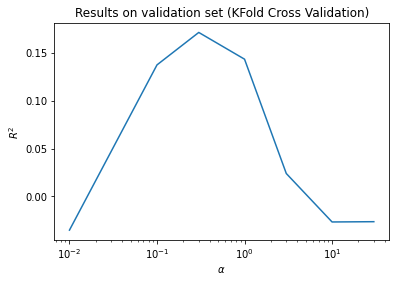

In [48]:
plt.plot([p['lasso__alpha'] for p in grid.cv_results_['params']],
         grid.cv_results_['mean_test_score'])
plt.xscale('log')
plt.xlabel('$\\alpha$')
plt.ylabel('$R^2$')
plt.title('Results on validation set (KFold Cross Validation)');

In [49]:
grid.best_score_

0.17122054870401587

In [50]:
grid.best_estimator_.named_steps['lasso'].coef_

array([ 14.60077969,   2.92004621,  -4.60039279,  -2.81916452,
        -9.00075712,   0.        ,   2.50296494,   0.        ,
        -0.        ,  -0.        ,  -0.        ,   0.        ,
        -0.        ,  -0.        ,  -0.        ,  -0.        ,
        -0.        ,  -0.        ,  -0.        ,  -0.        ,
         0.        ,  -0.        ,  -0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,  -0.        ,
         0.        ,  -0.14929035,   0.        , -13.60804025,
         0.        ,   4.02382564, -10.68037017,  -0.        ,
        -0.        ,   7.54467432,  -0.        ,  31.36215103,
         0.        ,  -5.27298285,  -6.34694991,  -0.        ,
         6.00918026,  -0.        ,   0.        ,  10.02667572,
        -0.        ,   0.        ])

In [51]:
important_features = pd.DataFrame(zip(grid.best_estimator_.named_steps['lasso'].coef_, X.columns), 
                                 columns=['coef', 'feature'])
important_features[abs(important_features.coef)>0]

,coef,feature
0,14.600780,directionCode_3.0
1,2.920046,directionCode_1.0
2,-4.600393,directionCode_2.0
3,-2.819165,directionCode_4.0
4,-9.000757,directionCode_nan
6,2.502965,r_12
29,-0.149290,dayname_Mon
31,-13.608040,dayname_Sat
33,4.023826,mtype_Suburban
34,-10.680370,mtype_Hyper


The important features that are not constant across a store are
- $r_{12}$
- whether it is Monday or Saturday (which makes sense given what we saw in distributions for days of the week)
- $\log(\text{revenue})$

### $\S$3.2: Let's look at feature importances from a tree

Let's see if a RandomForest regressor gives similar results, especially for which features are important. Note that we should avoid using the standard feature importance, especially as we have one-hot-encoded features (see [this article](https://explained.ai/rf-importance/)). We do not have to worry about scaling for the tree-based methods

In [156]:
# Warning -- this cell takes 

param_tree = {
    'max_depth': [30, 100, 150],
    'max_features': [10, 11, 12, 13, 14],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [80, 100, 200, 300]
}


# Create a based model
rf = RandomForestRegressor()


grid_tree = GridSearchCV(estimator=rf, 
                         param_grid=param_tree, 
                         cv=folds.split(X, y, groups)).fit(X, y)

In [157]:
grid_tree.best_score_

0.23252865465516087

## Let's check the sensitivity of the score to the parameters used

In [158]:
grid_tree.best_params_

{'max_depth': 30,
 'max_features': 13,
 'min_samples_leaf': 5,
 'min_samples_split': 10,
 'n_estimators': 100}

Let's look along each dimension / parameter value and plot the score as we change the values (holding the others constant)

In [159]:
df_parameters = pd.DataFrame(grid_tree.cv_results_)



In [160]:
def plot_scan_parameter(param_to_scan, best_params, df_parameters=df_parameters):
    """Sensitivity analysis for hyper-parameters
    
    Holds the other hyperparameters constant at their optimal values,
    and scans df_parameters to see how the mean score (R^2) changed across
    as we moved the `param_to_scan`.
    
    Also includes the 1-sigma variation in the score from the changes we
    see looking at different folds
    """
    mask = pd.Series(True, index=df_parameters.index)
    column_name = f'param_{param_to_scan}'
    
    for key, value in best_params.items():
        if key==param_to_scan:
            continue
        mask = mask & (df_parameters[f'param_{key}']==value)
    df_selection = df_parameters[mask].sort_values(column_name).copy()
    df_selection.plot(x=column_name, y='mean_test_score')
    df_selection[column_name] = df_selection[column_name].astype(float)
    plt.fill_between(x=df_selection[column_name],
                     y1=df_selection['mean_test_score'] + df_selection['std_test_score'],
                     y2=df_selection['mean_test_score'] - df_selection['std_test_score'],
                     alpha=0.3
                    )
    plt.ylabel('average OOS R2')
    plt.title(f'R2 OOS changes vs parameter {param_to_scan}')
    

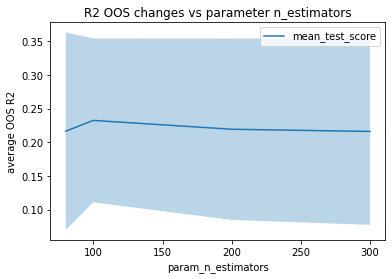

In [161]:
plot_scan_parameter('n_estimators', grid_tree.best_params_)

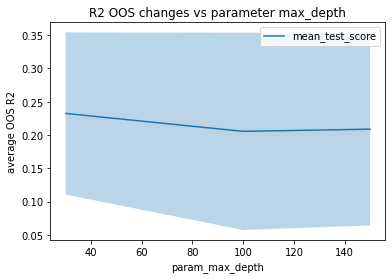

In [162]:
plot_scan_parameter('max_depth', grid_tree.best_params_)

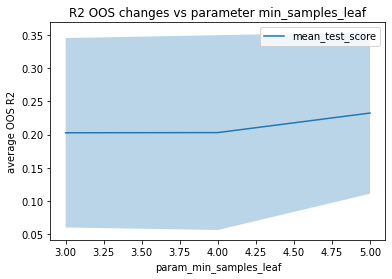

In [163]:
plot_scan_parameter('min_samples_leaf', grid_tree.best_params_)

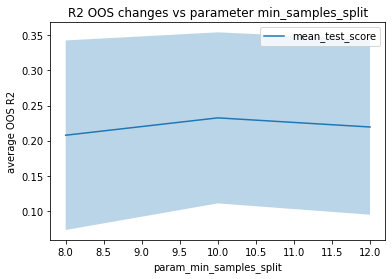

In [164]:
plot_scan_parameter('min_samples_split', grid_tree.best_params_)

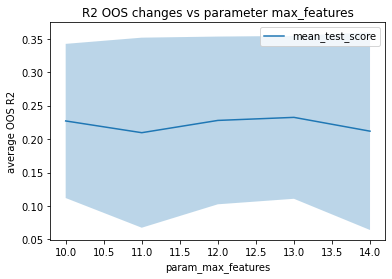

In [165]:
plot_scan_parameter('max_features', grid_tree.best_params_)

We see that we are not incredibly sensitive to the values used (especially when compared to the size of the 1-$\sigma$ error bars), so we don't gain a lot by altering the hyper parameters more.

Let's look at what the important features are (using permutation importance)

In [166]:
importances = permutation_importance(grid_tree, X, y, n_repeats=30)

In [167]:
for index in importances.importances_mean.argsort()[::-1]:
    # are we outside of a one-sigma error?
    if importances.importances_std[index] < abs(importances.importances_mean[index]):
        print(f'{X.columns[index]}\t\t{importances.importances_mean[index]:.2f} +/- {importances.importances_std[index]:.2f}')


isholiday		0.25 +/- 0.01
log_revenue		0.22 +/- 0.01
log_activities		0.14 +/- 0.00
log_transaction		0.09 +/- 0.00
r_33		0.05 +/- 0.00
r_11		0.04 +/- 0.00
r_1e		0.04 +/- 0.00
r_44		0.04 +/- 0.00
dayname_Sun		0.04 +/- 0.00
region_8.0		0.04 +/- 0.00
r_21		0.03 +/- 0.00
r_22		0.03 +/- 0.00
region_2.0		0.03 +/- 0.00
dayname_Mon		0.03 +/- 0.00
r_2e		0.03 +/- 0.00
r_31		0.03 +/- 0.00
r_41		0.03 +/- 0.00
r_32		0.03 +/- 0.00
r_3e		0.02 +/- 0.00
r_23		0.02 +/- 0.00
r_42		0.02 +/- 0.00
r_14		0.02 +/- 0.00
r_4e		0.02 +/- 0.00
mtype_Hyper		0.02 +/- 0.00
r_34		0.02 +/- 0.00
r_12		0.02 +/- 0.00
dayname_Tue		0.02 +/- 0.00
r_43		0.02 +/- 0.00
r_24		0.02 +/- 0.00
r_13		0.02 +/- 0.00
directionCode_1.0		0.01 +/- 0.00
mtype_Suburban		0.01 +/- 0.00
dayname_Sat		0.01 +/- 0.00
region_5.0		0.01 +/- 0.00
region_1.0		0.01 +/- 0.00
region_3.0		0.01 +/- 0.00
directionCode_3.0		0.00 +/- 0.00
directionCode_2.0		0.00 +/- 0.00
mtype_Urban		0.00 +/- 0.00
dayname_Thu		0.00 +/- 0.00
region_9.0		0.00 +/- 0.00
directionCode

## $\S$3.3: Model reducing the unnecessary features of model 3.2

We see there is a really high variance in the models in section 3.2 when looking at the standard error of the different folds. Let's eliminate some of the less useful variables in our model, and refit.

We will eliminate features with permuation importance less than 0.02 as a starting point (normally we would eliminate features one at a time, as features could have low importance due to colinearity and they end up splitting importance between them, but in the interest of time we make this shortcut).

In [347]:
features_to_keep = [c for c, importance in zip(X.columns, importances.importances_mean) if importance > 0.02]
features_to_keep

['r_11',
 'r_12',
 'r_14',
 'r_1e',
 'r_21',
 'r_22',
 'r_23',
 'r_2e',
 'r_31',
 'r_32',
 'r_33',
 'r_34',
 'r_3e',
 'r_41',
 'r_42',
 'r_44',
 'r_4e',
 'dayname_Sun',
 'dayname_Mon',
 'dayname_Tue',
 'mtype_Hyper',
 'isholiday',
 'region_2.0',
 'region_8.0',
 'log_revenue',
 'log_transaction',
 'log_activities']

In [348]:
X_2 = X[features_to_keep].copy()
y_2 = y.copy()  # not strictly necessary, but makes easier to read/follow

In [ ]:
# Warning -- this cell takes 

param_tree = {
    'max_depth': [30, 100, 150],
    'max_features': [10, 11, 12, 13, 14],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [80, 100, 200, 300]
}


# Create a based model
rf = RandomForestRegressor()


grid_tree_reduced = GridSearchCV(estimator=rf,
                                 param_grid=param_tree, 
                                 cv=folds.split(X_2, y_2, groups)).fit(X_2, y_2)

## $\S$3.4: Model encoding the categorical variables using target encoder

Here we have one-hot encoded the region, which seems like an important feature (at least region 2 and region 8 showed as significant, and many region variables showed up as important in the Lasso model).

Let's also just double check the number of stores in each region. Usually you would do this on a holdout sample, but here we have stores in a single region

In [231]:
train.groupby('region').store_id.nunique()

region
1     7
2     2
3     2
4     1
5     3
6     1
7     2
8     3
9     3
10    1
Name: store_id, dtype: int64

In [230]:
train.groupby('region').deltaRevenue.mean()

region
1      4.184629
2    -16.172806
3     -7.170191
4     -5.139121
5      7.203413
6     -0.730733
7     10.155401
8      8.285588
9     -7.323255
10   -10.666819
Name: deltaRevenue, dtype: float64

What stops us from applying something that `ce.TargetEncoder` is the repeated data. We have many rows of data corresponding to the same store, and `ce.TargetEncoder` treats these as if they were independent! This is pretty hard to cross-validate, as some regions only have one store. For example, the $-10$ points in region 10 doesn't really tell us about region 10; it tells us about the single store in region 10 in our dataset (it might be that store is bad, rather than a competitive region).

With so few stores in a region, I am worried about overfitting - a more sophisticated model (with more time) would try to do proper hierarchical modeling of stores on regions. So sadly I will be deleting region (accepting slightly more variance and reducing bias).

I do feel a little more comfortable with the market type:

In [240]:
train.groupby('mtype').agg({'store_id': 'nunique', 'deltaRevenue': 'mean'})

,store_id,deltaRevenue
mtype,,
Hyper,5,4.065059
Rural,3,-3.337324
Suburban,5,-8.018418
Urban,12,1.664466


The shifts are not as big as region, but it is easier to validate / extend. We also have for `directionCode`

In [241]:
train.groupby('directionCode').agg({'store_id': 'nunique', 'deltaRevenue': 'mean'})

,store_id,deltaRevenue
directionCode,,
1.0,8,-3.767967
2.0,3,5.497128
3.0,7,-0.673628
4.0,6,2.478701


##### A shortcut (i.e. technically wrong)

We still cannot do naive cross validation by row. Instead we need to do target encoding by the individual store, so the _right_ way of doing it is, in each fold,
1. Find the mean for each store of the target
2. Find the std dev between the means of stores in the same `mtype` (or `directionCode`). This will have approximately 20 rows (4 out of 5 folds, where each store appears in only one fold)
3. Train the target encoder on the 20 rows. It will shrink the values toward the global mean of the target (the more variation there is between the mean of stores in the same `mtype`, the more weight the global mean carries)
4. Apply the encoder to the full data frame with many repeated rows

It is hard to fit this into GridSearchCV, so I'd have to do something custom or write my own Pipeline stage (or use PyMC3). 

So the method below is pragmatic, but does incur data leakage!

In [297]:
train = load_data('data/train.csv')
train = store_id_encoder.transform(train)

In [298]:
mtype_revenue_by_store = train.groupby(['mtype', 'store_id']).deltaRevenue.mean()
mtype_revenue_by_store

mtype     store_id
Hyper     6           -5.139121
          10          -3.481491
          12          10.570597
          15          16.477892
          18          -2.156273
Rural     11           5.346415
          19         -16.575726
          24          17.227659
Suburban  3          -15.844144
          9            7.139291
          21         -23.437964
          22           4.597923
          23           7.187273
Urban     1            5.995231
          2           -0.984420
          4            6.160937
          5          -11.411450
          7           11.117389
          8           -0.730733
          13           9.104548
          14           3.176659
          16           6.168674
          17           0.868651
          20           9.255503
          25         -10.666819
Name: deltaRevenue, dtype: float64

Within each group of `mtype`, we will calculate the mean and standard deviation:

In [299]:
mtype_summary = mtype_revenue_by_store.reset_index().groupby('mtype').agg({'deltaRevenue':['mean', 'std'], 'store_id': 'count'})
mtype_summary.columns=['mean', 'std', 'n_stores']
mtype_summary

,mean,std,n_stores
mtype,,,
Hyper,3.254321,9.662897,5
Rural,1.999449,17.148435,3
Suburban,-4.071524,14.502205,5
Urban,2.337848,7.353852,12


Now let's get the overall mean and std:

In [300]:
DELTA_REV_MEAN_ACROSS_STORES = mtype_revenue_by_store.mean()
DELTA_REV_STD_IN_MEAN_ACROSS_STORES = mtype_revenue_by_store.std()

print(f"Mean ={DELTA_REV_MEAN_ACROSS_STORES:.2f}, stddev={DELTA_REV_STD_IN_MEAN_ACROSS_STORES:.2f}")

Mean =1.20, stddev=10.36


Now we apply the shinkage trick, as outlined [here](https://kiwidamien.github.io/derivations-and-conjugate-priors-average-ratings.html). Again, the intuition is that if the variance within a group is large (e.g. Rural) we bias toward the global average. If it is small, we bias toward the group average. Here "big" and "small" are made by comparing to the average of all stores (disregarding the `mtype`).

We have

$$\text{encoded value for cat $i$} = B_i \bar{x_i} + (1-B_i)\mu, \quad\quad B_i = \frac{\tau^2}{\tau^2 + (\sigma_i^2/\text{n_stores})}$$

where $\bar{x}_i$ is the mean for category $i$ (across stores), $\mu$ is the global mean, $\tau$ is the global std dev, and $\sigma_i$ is the std dev in the target for that store.

In [301]:
mtype_summary['B'] = (mtype_summary.apply(
    lambda row: DELTA_REV_STD_IN_MEAN_ACROSS_STORES**2/(DELTA_REV_STD_IN_MEAN_ACROSS_STORES**2 + (row['std']**2/row.n_stores)),
    axis=1)
                     )

In [302]:
mtype_summary

,mean,std,n_stores,B
mtype,,,,
Hyper,3.254321,9.662897,5,0.851763
Rural,1.999449,17.148435,3,0.522596
Suburban,-4.071524,14.502205,5,0.718389
Urban,2.337848,7.353852,12,0.959694


We see that `Hyper` and `Urban` (with lower std than the entire population) have $B>0.5$, so the mean is weighted more toward the group value. Working as expected!

In [303]:
mtype_summary['encoded'] = mtype_summary['B']*mtype_summary['mean'] + (1-mtype_summary['B'])*DELTA_REV_MEAN_ACROSS_STORES

In [304]:
mtype_summary

,mean,std,n_stores,B,encoded
mtype,,,,,
Hyper,3.254321,9.662897,5,0.851763,2.949597
Rural,1.999449,17.148435,3,0.522596,1.617150
Suburban,-4.071524,14.502205,5,0.718389,-2.587383
Urban,2.337848,7.353852,12,0.959694,2.291931


Now let's use this encoded value in the dataset:

In [305]:
train['encoded_mtype'] = train.mtype.apply(lambda value: mtype_summary.loc[value, 'encoded'])
train = train.drop('mtype', axis=1)

In [306]:
# We also only saw importance for Sun, Mon, Tue
train['is_mon'] = (train['dayname']=='Mon').astype(int)
train['is_tue'] = (train['dayname']=='Tue').astype(int)
train['is_wed'] = (train['dayname']=='Wed').astype(int)
train = train.drop('dayname', axis=1)

In [307]:
train = train.drop(['store_id', 'directionCode', 'region'], axis=1)

In [308]:
X_3, y_3 = train.drop(['deltaRevenue'], axis=1), train.deltaRevenue

Let's use our previous best fit features to make a starting point here:

In [309]:
param_tree = {
    'max_depth': [100, 150, 200],
    'max_features': [13, 14, 15, 16],
    'min_samples_leaf': [5, 8, 10],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [80, 100, 200]
}
# Create a based model
rf = RandomForestRegressor()


grid_tree_encoded = GridSearchCV(estimator=rf, 
                                 param_grid=param_tree, 
                                 cv=folds.split(X_3, y_3, groups)).fit(X_3, y_3)

In [314]:
grid_tree_encoded.best_score_

0.10671986602834353

In [315]:
grid_tree_encoded.best_params_

{'max_depth': 150,
 'max_features': 14,
 'min_samples_leaf': 5,
 'min_samples_split': 8,
 'n_estimators': 80}

Our method to encode the market type actually made the score (significantly) worse, so let's stay with the original tree model

### $\S$3.4: summary of models

We tried three models, all selected with the goal of being able to do feature reduction. The models were:


1. **LASSO** simple Lasso, with cross-validation to determine regularization
2. **Basic forest**, a random forest, with categorical variables one-hot encoded
3. **Reduced forest**, a random forest on a reduced set of features, to try and counteract the wide variance seen between folds in model 2
4. **Advanced forest**, a random tree, using feature selection (via 2) and trying to use the target to determine the encoding for the market type (done in a way that leaked data).

I found model 2 performed the best, and the extra information from encoding the market category in model 4 made the model worse. This suggests that we really were encoding information about the specific stores when training, and we cannot use this feature without doing a lot more modeling.

We move to validation with the **Basic forest**

## $\S$4. Validation

Note that by default, `GridSearchCV` has `refit=True`, and fits the best parameter on _all_ the training data. However, it is better to ensure that we have prepared the data identically, so we will retrain the model using the best parameters for `grid_tree`.

Let's reload the data and train on everything, with a reproducible data pipeline:

In [329]:
def prepare_data(path, exclude_outputs_greater_than=float('inf')):
    df = load_data(path, exclude_outputs_greater_than=exclude_outputs_greater_than)
    print(f"Highest magnitude still in output: {abs(df.deltaRevenue).max():,.2f}")
    df = ohe_encoder.transform(df)
    df = df.drop(['store_id'], axis=1)
    # Note that tree-based methods don't need standard scaling
    
    return df.drop(['deltaRevenue'], axis=1), df.deltaRevenue
    
    

In [331]:
X_train, y_train = prepare_data(path='data/train.csv', exclude_outputs_greater_than=300)

# Let's not cut off outliers in the validation set, unless it is obviously a typo of some sort!
X_val, y_val = prepare_data(path='data/validation.csv', exclude_outputs_greater_than=float('inf'))

Highest magnitude still in output: 267.98
Highest magnitude still in output: 311.45


Okay, this looks good. We should also check we have the same columns, and in the same order!

In [339]:
def column_check(X_train, X_val):
    newline = "\n"
    mismatches = [f"col #{index}: {c_train} <--> {c_val}" 
                  for index, (c_train, c_val) in enumerate(zip(X_train.columns, X_val.columns))
                  if c_train != c_val
                 ]
    msg = ("Misaligned columns check:\n" + 
           "\n".join(mismatches))
    return msg


print(column_check(X_train, X_val))

Misaligned columns check:
col #36: isholiday <--> region_1.0
col #37: region_1.0 <--> region_2.0
col #38: region_2.0 <--> region_3.0
col #39: region_3.0 <--> region_4.0
col #40: region_4.0 <--> region_5.0
col #41: region_5.0 <--> region_6.0
col #42: region_6.0 <--> region_7.0
col #43: region_7.0 <--> region_8.0
col #44: region_8.0 <--> region_9.0
col #45: region_9.0 <--> region_10.0
col #46: region_10.0 <--> isholiday


Okay, that is really frustrating that the columns come in different orders. At least we have the same labels, just permuted. Let's put validation in the same order as training:

In [342]:
X_val = X_val[X_train.columns]
print(column_check(X_train, X_val))

Misaligned columns check:



Yay, all columns are aligned

In [344]:
final_model = RandomForestRegressor(**grid_tree.best_params_)
final_model.fit(X_train, y_train)
final_model.score(X_train, y_train)

0.6771829584515269

In [345]:
final_model.score(X_val, y_val)

0.12947917286059363

## $\S$ 5: Improvements

As mentioned a few times, one of the most challenging things about this dataset is that the rows were related because there were a few individual stores. Taking a standard approach, where the rows were treated separately, would not be appropriate, and would lead us to be overly confident in our results.

In particular, features like seats, parking spaces, market type, store type, and the region are repeated in a completely correlated way (there are only 25 unique combinations) so we can end up encoding a lot of information in these features that are encodings about the store, and would not generalize to new stores.

The way to approach this problem is probably to do a hierarichal model on the parameters that describe a store. I did a high level of this approach when encoding the `mtype` variable. To do it in a statistically robust way would be to set a prior on the distribution of these variables and the average outcome. We would replace all the features that were constant on a particular store with the output of this model as a feature in the time dependent set.

When given a new store, we would be able to calculate the store column. Because we only have 25 stores, we would need a fairly simple model, and would use statistical techniques (e.g. AIC or WAIC) to determine which features to keep, rather than using cross validation.